In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

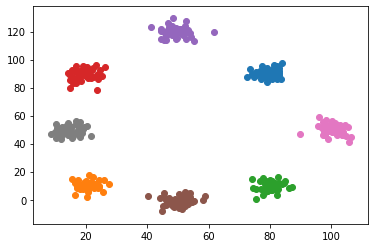

In [3]:
n_samps = 50

means = np.array([[8,9], [2,1], [8,1], [2,9], [5,12], [5,0], [10, 5], [1.5,5]]) * 10
data = np.zeros((len(means)*n_samps,2))
y = np.zeros((len(means)*n_samps,1))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)/0.1).rvs(n_samps)#.astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    y[ind*n_samps:((ind+1)*n_samps)] = np.tile(ind, n_samps).reshape(-1,1)
    plt.scatter(samps[:,0], samps[:,1])


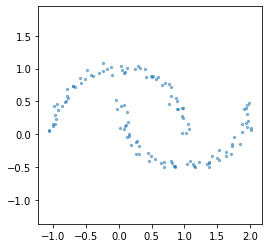

In [65]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetSIGGRAPH:
    """ 
    haha, found from Eric https://blog.evjang.com/2018/01/nf2.html
    https://github.com/ericjang/normalizing-flows-tutorial/blob/master/siggraph.pkl
    """
    def __init__(self):
        with open('siggraph.pkl', 'rb') as f:
            XY = np.array(pickle.load(f), dtype=np.float32)
            XY -= np.mean(XY, axis=0) # center
        self.XY = torch.from_numpy(XY)
    
    def sample(self, n):
        X = self.XY[np.random.randint(self.XY.shape[0], size=n)]
        return X

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

def eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(data)), batch_size)
    return data[rand,:]

def oh_eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(oh)), batch_size)
    return oh[rand,:]
    
d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [130]:
def torch_oh(input, vocab_size, axis=-1):
    input = input-input.min()
    x = input.flatten().unsqueeze(1).long()
    z = torch.zeros((input.shape[0]*input.shape[1], vocab_size ))
    z.scatter_(1,x,1)
    z = z.view(input.shape[0], input.shape[1], vocab_size)
    return z

torch.Size([64, 2])


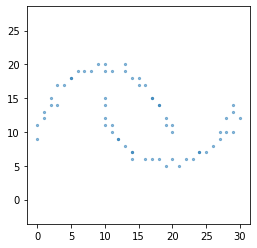

In [131]:
import disc_utils
ds_moons = DatasetMoons()
moons_vocab_size = 35
# need to make one hot. 
def int_moons_sample(batch_size):
    x = ds_moons.sample(batch_size)*10
    x = x.type(torch.int)
    x = torch_oh(x, moons_vocab_size, axis=-1)
    return x

x = int_moons_sample(64).argmax(-1)
print(x.shape)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [82]:
print(x.max(), x.min())

tensor(20, dtype=torch.int32) tensor(-10, dtype=torch.int32)


In [5]:
data.shape

(400, 2)

In [6]:
batch_size, sequence_length, vocab_size = 32,  2, 150

def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            res[ind, j, :] = idd[int(val)]
            
    return res
            

oh = one_hotter(data, vocab_size)

In [178]:
from MADE import *
from flows import *
from spline_flows import NSF_AR, NSF_CL

base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), torch.eye(2))


# RealNVP
#flows = [AffineHalfFlow(dim=2, parity=i%2) for i in range(9)]

# NICE
#flows = [AffineHalfFlow(dim=2, parity=i%2, scale=False) for i in range(4)]
#flows.append(AffineConstantFlow(dim=2, shift=False))

# SlowMAF (MAF, but without any parameter sharing for each dimension's scale/shift)
# flows = [SlowMAF(dim=2, parity=i%2) for i in range(4)]

# MAF (with MADE net, so we get very fast density estimation)
flows = [MAF(dim=2, parity=i%2) for i in range(4)]

# Neural splines, coupling
'''nfs_flow = NSF_CL if True else NSF_AR
flows = [nfs_flow(dim=2, K=8, B=3, hidden_dim=16) for _ in range(3)]
convs = [Invertible1x1Conv(dim=2) for _ in flows]
norms = [ActNorm(dim=2) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))'''


model = NormalizingFlowModel(base, flows)

In [8]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  5488


In [9]:
base.sample((100,));

In [10]:
type(torch.Tensor(data[:batch_size,:]))

torch.Tensor

forward is from data to latent. backward is from latent to data

In [11]:
epochs = 15000
batch_size = 248
learning_rate=0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

#x = torch.Tensor(data[:batch_size,:])

model.train()
for e in range(epochs): 
    
    #x = d.sample(batch_size)
    x = torch.Tensor(eightMixture_sample(batch_size))
    
    optimizer.zero_grad()
    
    zs, prior_logprob, log_det = model.forward( x )
    # get the back output after every transformation currently!
    #print(back_probs)
    logprob = prior_logprob + log_det
    loss = -torch.sum(logprob)
    #print(loss)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%100==0:
        print(e, loss.item())
    
    
plt.plot(losses)
    

0 31729980.0
100 5319970.0
200 3094805.75
300 2209843.0
400 1703109.375
500 1372396.625
600 1205545.25
700 1101721.5
800 970992.875
900 872133.75
1000 701831.6875
1100 692740.75
1200 590573.3125
1300 559430.3125
1400 567803.0
1500 511533.375
1600 462751.75
1700 457484.46875
1800 434756.0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-1241853afd91>", line 25, in <module>
    optimizer.step()
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/torch/optim/adam.py", line 93, in step
    exp_avg.mul_(beta1).add_(1 - beta1, grad)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/IPy

KeyboardInterrupt: 

Text(0.5, 1.0, 'z -> x')

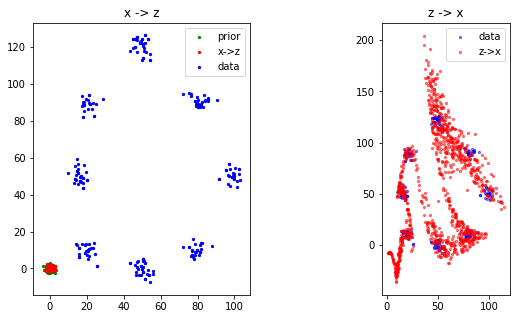

In [54]:
model.eval()

#x = d.sample(128)
x = torch.Tensor(eightMixture_sample(batch_size))
zs, prior_logprob, log_det = model(x)
z = zs[-1]

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample([128, 2]).squeeze()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.sample(128*8)
z = zs[-1]
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

In [62]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()

In [11]:
x = eightMixture_sample(batch_size)
plot2D(x)

NameError: name 'eightMixture_sample' is not defined

In [12]:
model.eval()

samps = model.sample(batch_size)[-1]
samps = samps.detach().numpy()
plot2D(samps)

NameError: name 'plot2D' is not defined

In [13]:
samps;

# Discrete Flows

In [221]:
from TorchDiscCode import *

In [248]:
nh = 32
batch_size= 124
sequence_length = 2
vocab_size = 35
temperature = 0.1
flows = []

for i in range(1):
    # if want to also learn the scale: 
    # MADE(vocab_size, [nh, nh, nh], 2*vocab_size, num_masks=1, natural_ordering=False)
    layer = MADE(vocab_size, [nh, nh, nh], vocab_size, num_masks=1, natural_ordering=False)
    disc_layer = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
    

In [249]:
oh[:64,:,:].shape

(64, 2, 150)

In [250]:
rand_source = torch.distributions.Normal(0,1).sample([batch_size, sequence_length, vocab_size])

rand_source.shape

torch.Size([124, 2, 35])

In [251]:
base = torch.distributions.OneHotCategorical(logits = rand_source )

(array([17., 12.,  3., 14., 17., 10., 12., 13., 12., 14.]),
 array([ 0. ,  3.3,  6.6,  9.9, 13.2, 16.5, 19.8, 23.1, 26.4, 29.7, 33. ]),
 <a list of 10 Patch objects>)

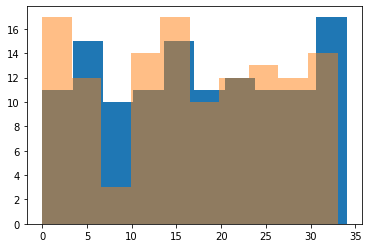

In [252]:
samps = base.sample().argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

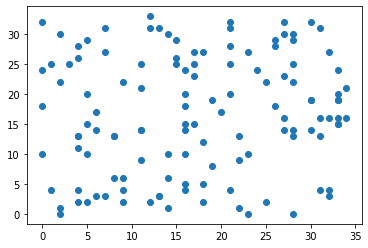

In [253]:
def plot2D(x):
    plt.scatter(x[:,0], x[:,1])
    plt.show()
    
plot2D(samps)

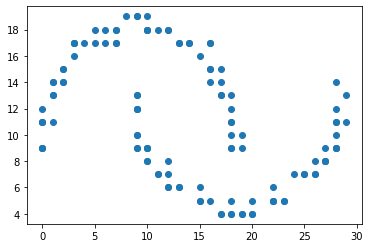

In [254]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))


MADE(
  (net): Sequential(
    (0): MaskedLinear(in_features=35, out_features=32, bias=True)
    (1): ReLU()
    (2): MaskedLinear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): MaskedLinear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): MaskedLinear(in_features=32, out_features=35, bias=True)
  )
)
torch.Size([35, 32])


(array([4., 0., 6., 5., 1., 4., 5., 1., 3., 3.]),
 array([-0.17613155, -0.14174114, -0.10735074, -0.07296035, -0.03856995,
        -0.00417954,  0.03021086,  0.06460126,  0.09899165,  0.13338205,
         0.16777246], dtype=float32),
 <a list of 10 Patch objects>)

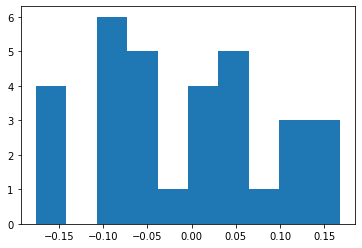

In [256]:
flow_num = 0
sub_part = 6
print(model.flows[flow_num]._modules['layer'])
w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'] 
print(w.shape)
plt.hist(w.detach().numpy()[0,:])

0 976.6187133789062


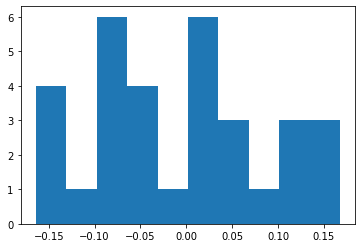

250 962.4197998046875


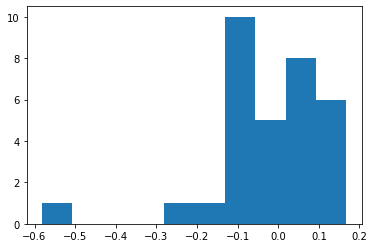

500 1004.6934814453125


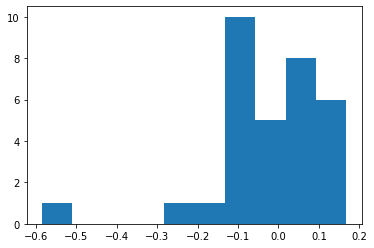

750 1016.1032104492188


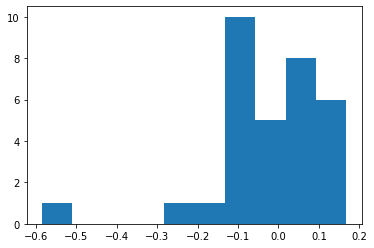

1000 997.0458374023438


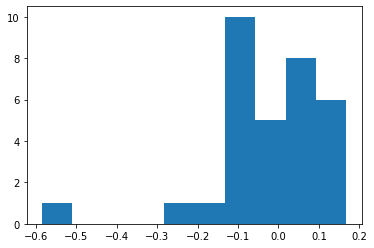

1250 998.700439453125


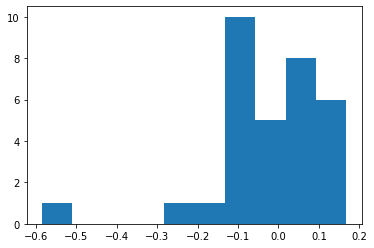

1500 1000.345703125


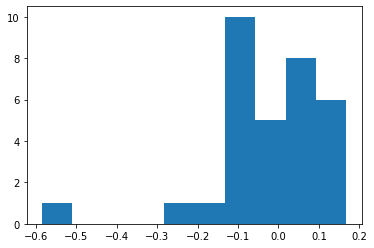

1750 998.1876220703125


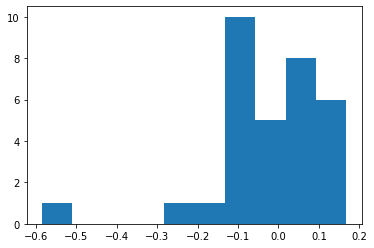

2000 975.4193725585938


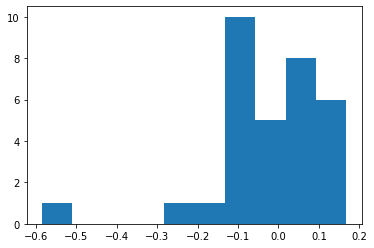

2250 977.0281372070312


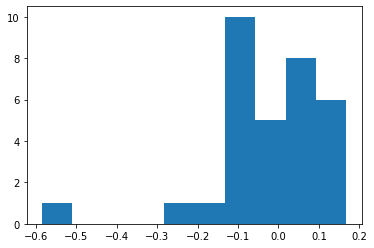

2500 986.9657592773438


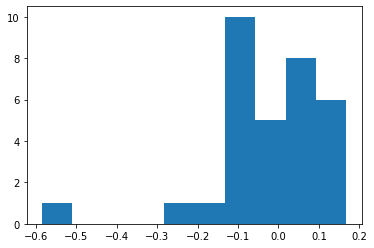

2750 990.2695922851562


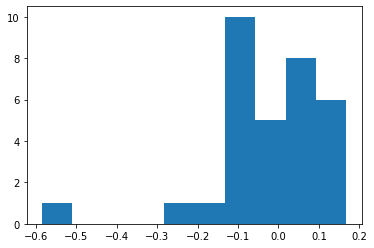

3000 997.6268920898438


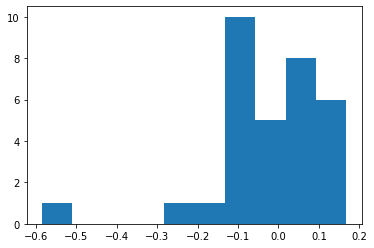

3250 1006.8363647460938


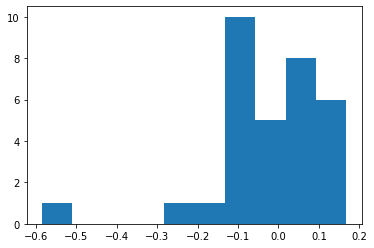

3500 1024.454833984375


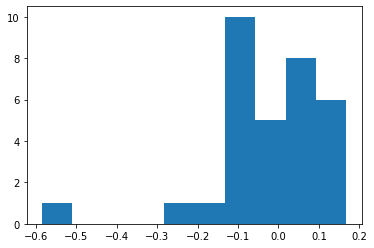

3750 988.9171142578125


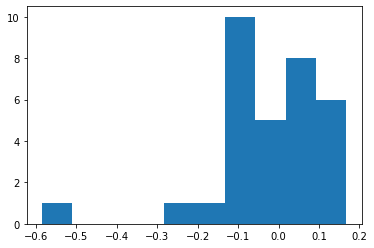

4000 1013.3273315429688


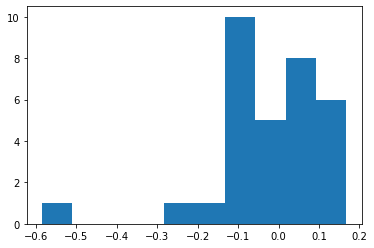

4250 1002.6539306640625


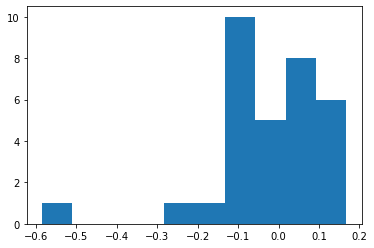

4500 1004.7647705078125


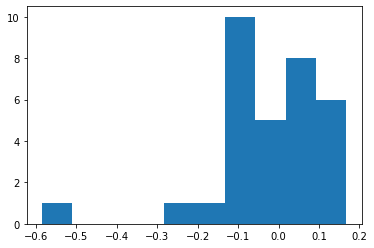

4750 979.65576171875


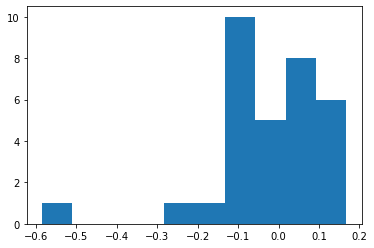

5000 1002.1923828125


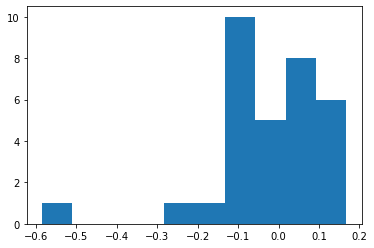

5250 1012.7860107421875


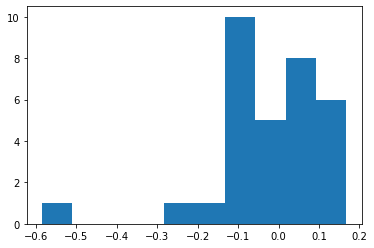

5500 995.39453125


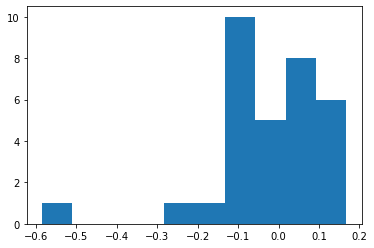

5750 976.8054809570312


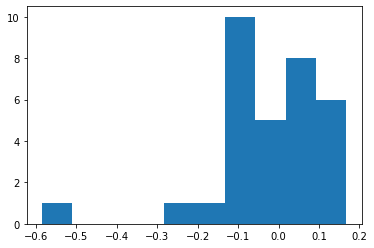

6000 994.4768676757812


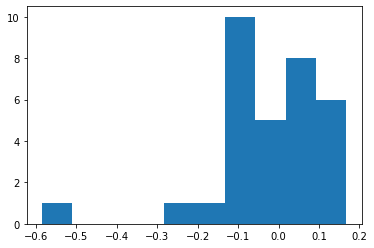

6250 986.5216674804688


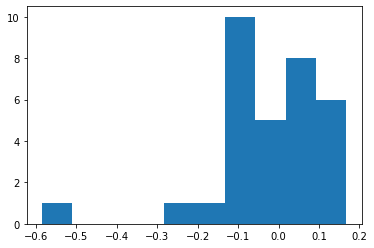

6500 1002.6031494140625


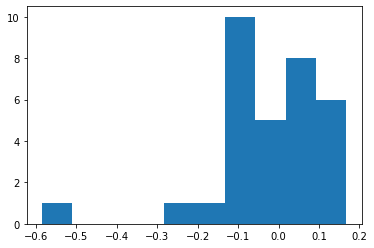

6750 992.9634399414062


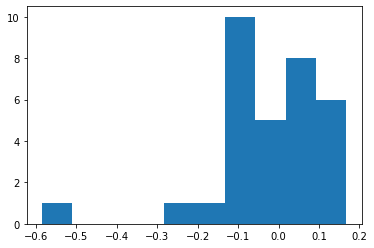

7000 1000.8152465820312


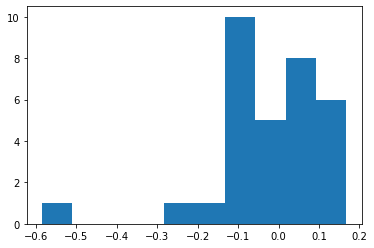

7250 971.4345092773438


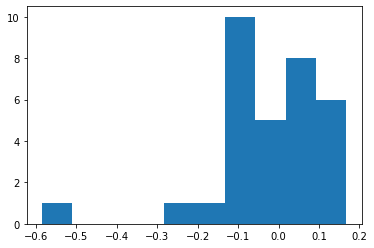

7500 1023.7718505859375


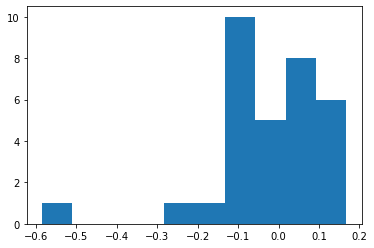

7750 986.7999267578125


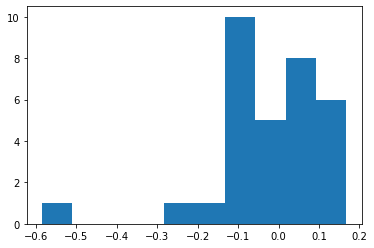

8000 1007.7171630859375


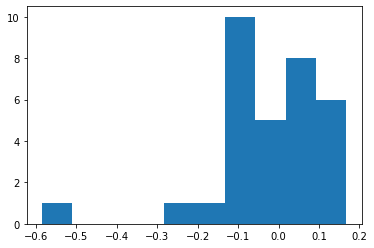

8250 993.778076171875


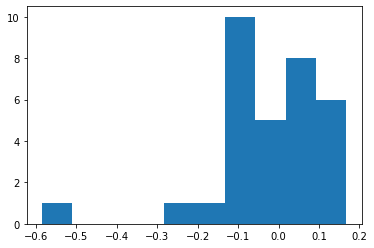

8500 991.5743408203125


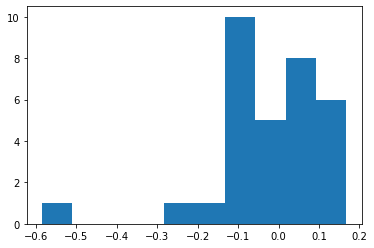

8750 978.4052734375


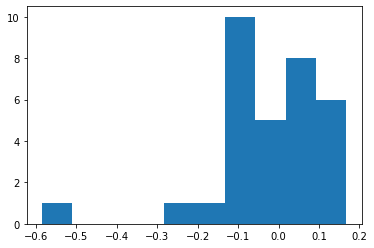

9000 1003.4857177734375


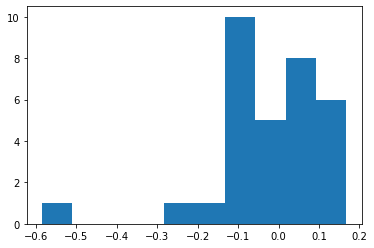

9250 1003.1690673828125


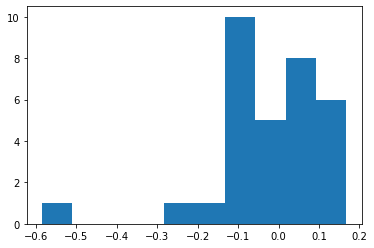

9500 977.8278198242188


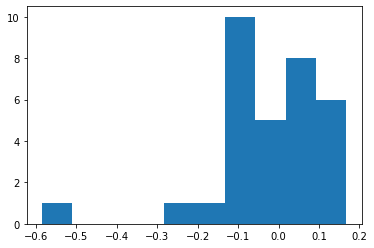

9750 1010.8461303710938


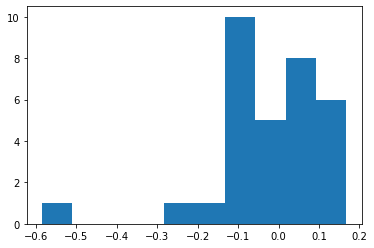

10000 1004.2003784179688


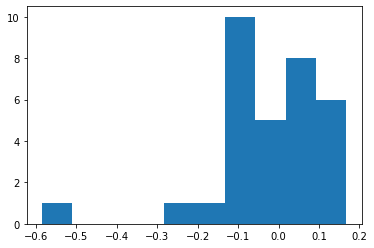

10250 994.5570068359375


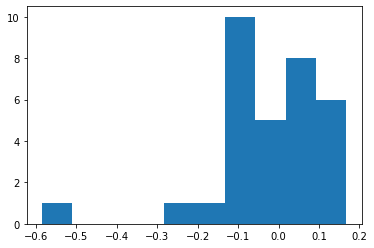

10500 956.9072265625


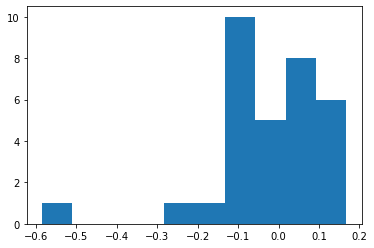

10750 984.35400390625


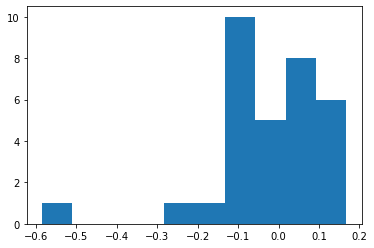

11000 989.45361328125


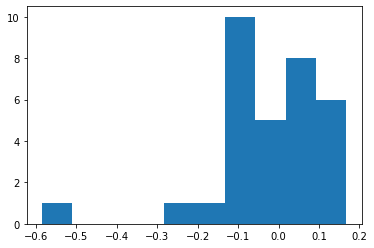

11250 997.3514404296875


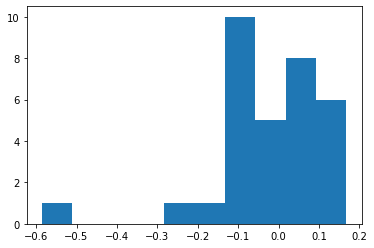

11500 1001.224853515625


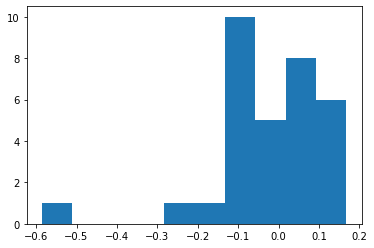

11750 1004.27783203125


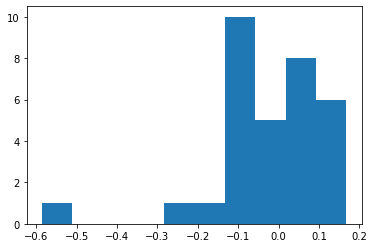

12000 991.516357421875


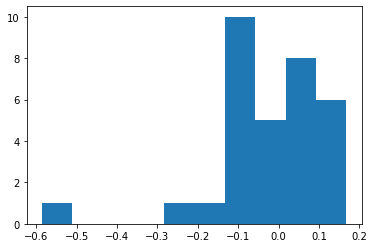

12250 992.655029296875


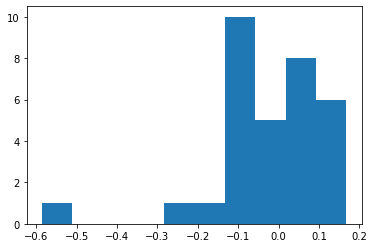

12500 1003.084716796875


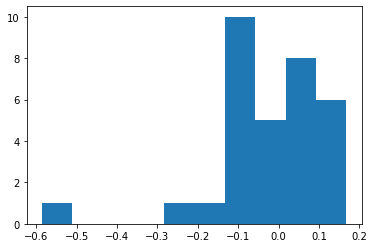

12750 1018.358642578125


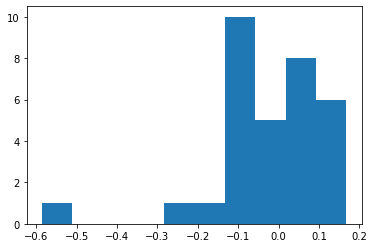

13000 1008.6818237304688


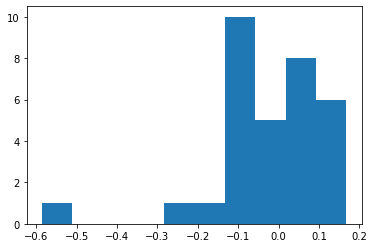

13250 1007.724365234375


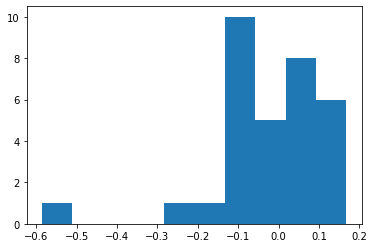

13500 1033.8319091796875


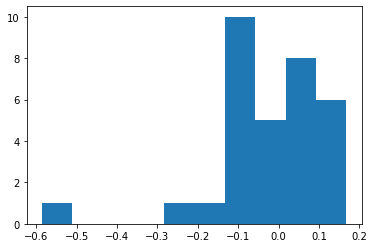

13750 975.40771484375


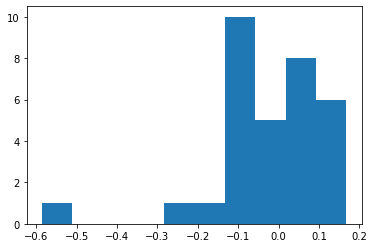

14000 1004.8365478515625


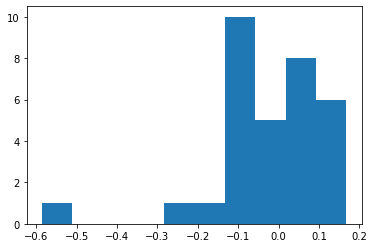

14250 982.058349609375


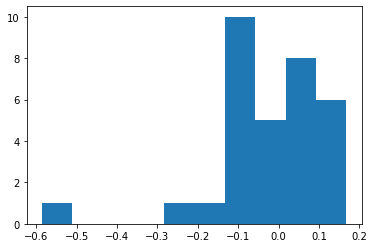

14500 973.500732421875


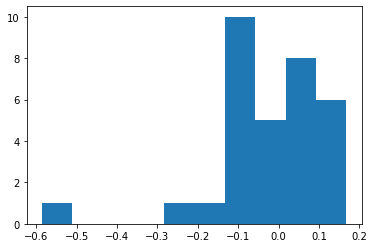

14750 995.1976318359375


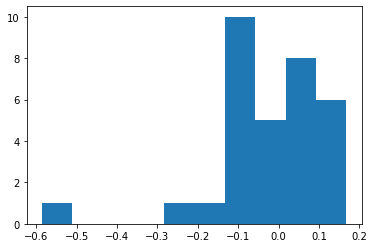

15000 988.347900390625


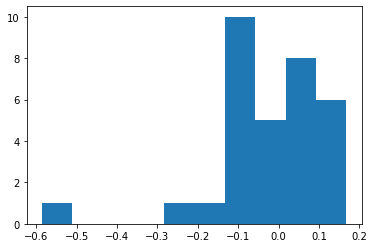

15250 996.6301879882812


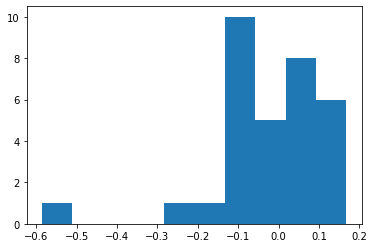

15500 1010.0197143554688


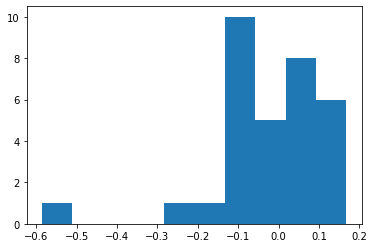

15750 1010.7801513671875


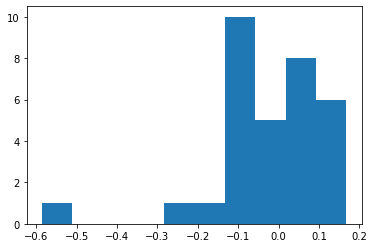

16000 998.5


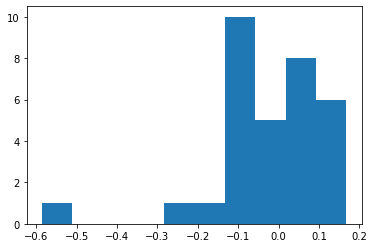

16250 988.7547607421875


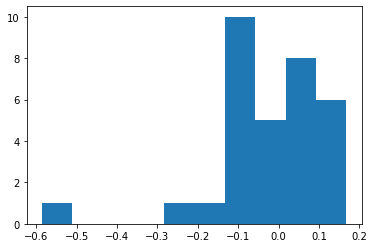

16500 996.259521484375


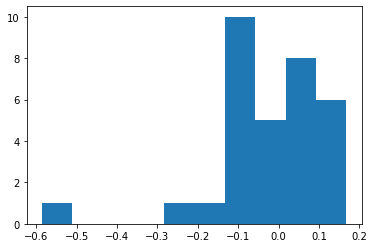

16750 990.5960693359375


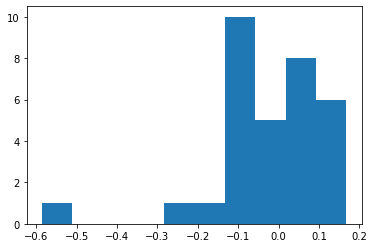

17000 996.1421508789062


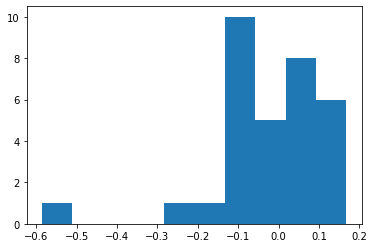

17250 1012.0145874023438


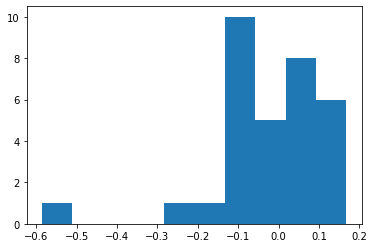

17500 1017.078857421875


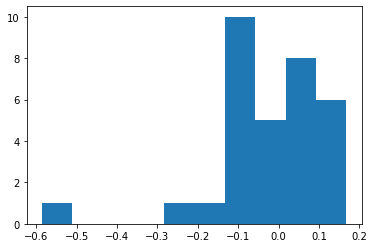

17750 1013.6788330078125


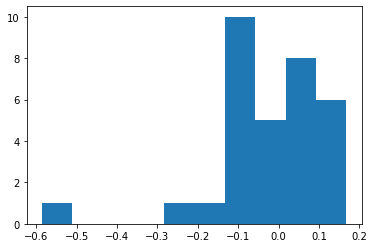

18000 981.806396484375


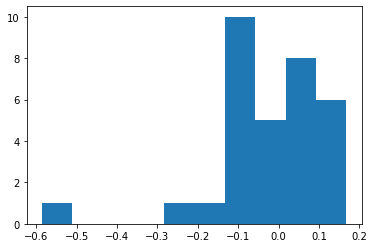

18250 988.7227172851562


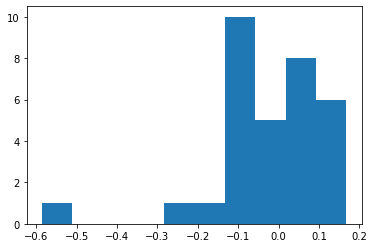

18500 990.3659057617188


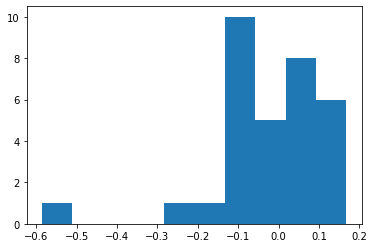

18750 1009.7396850585938


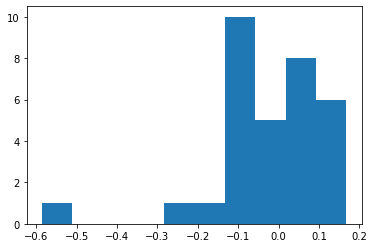

19000 1010.8641357421875


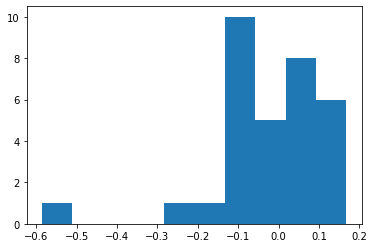

19250 1026.156005859375


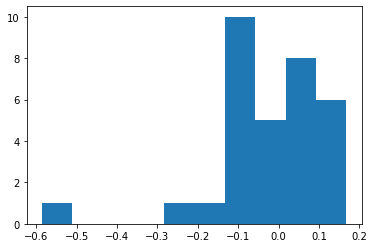

19500 1017.5345458984375


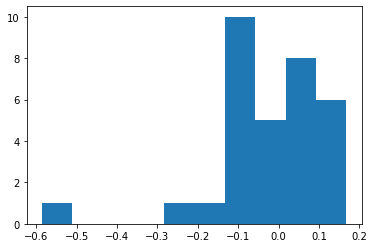

19750 990.5151977539062


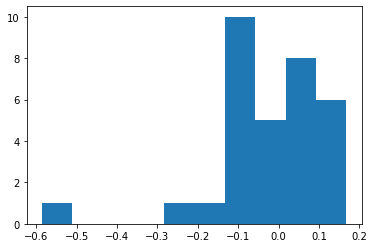

20000 999.3650512695312


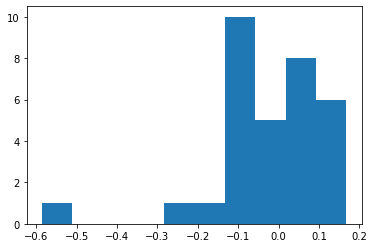

20250 991.8319091796875


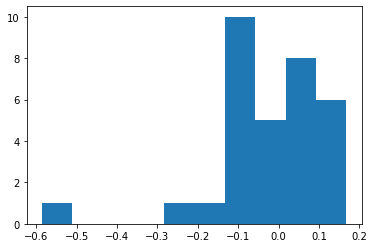

20500 1000.3513793945312


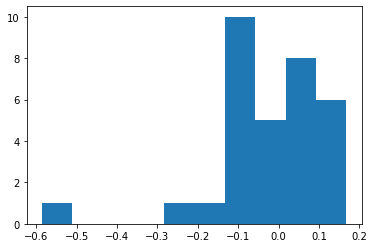

20750 991.4862060546875


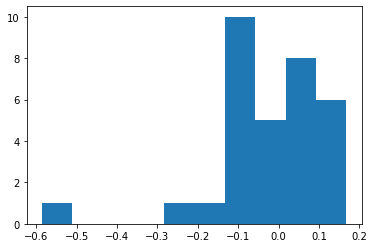

21000 1020.511474609375


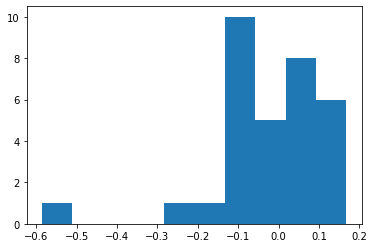

21250 987.500732421875


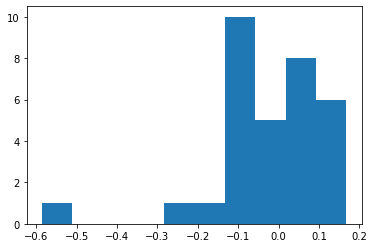

21500 991.3832397460938


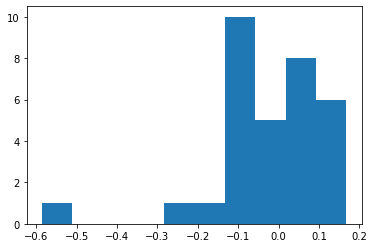

21750 994.726318359375


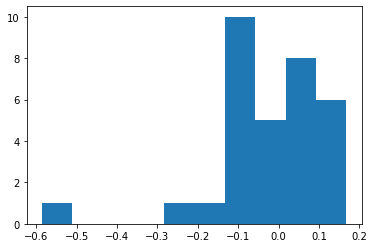

22000 976.17919921875


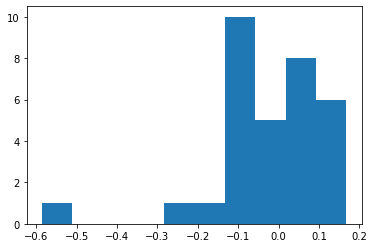

22250 970.9940185546875


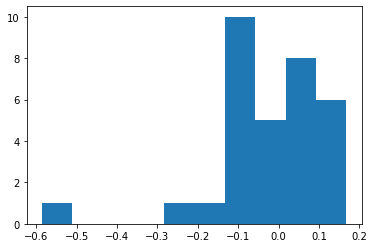

22500 1002.1035766601562


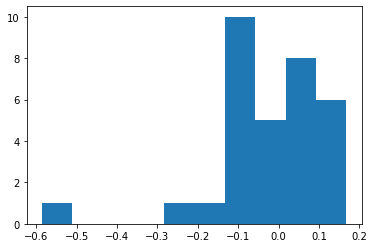

22750 995.7550048828125


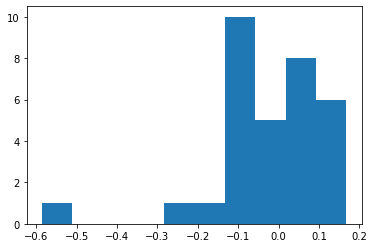

23000 1003.35546875


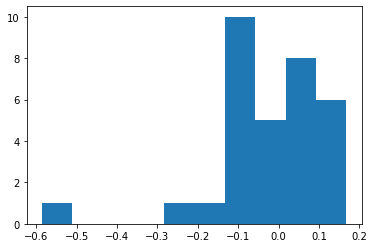

23250 961.248046875


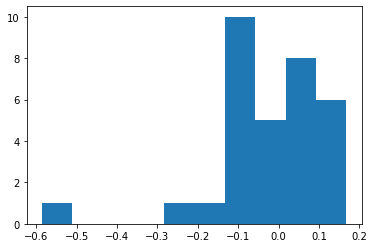

23500 992.0380859375


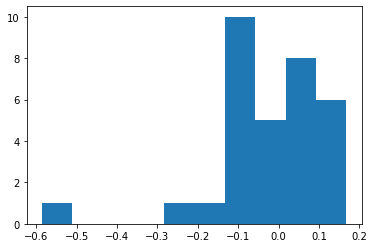

23750 997.8679809570312


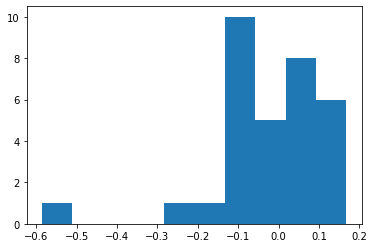

24000 970.0172119140625


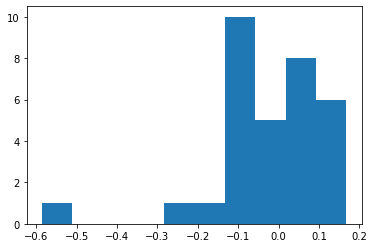

24250 1001.4138793945312


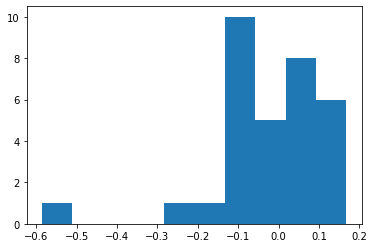

24500 984.6636962890625


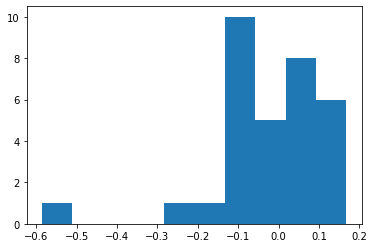

24750 967.5838012695312


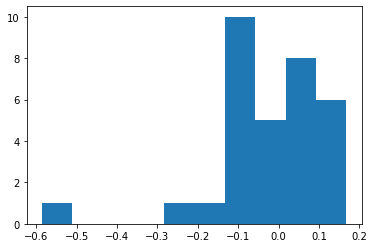

25000 1001.7543334960938


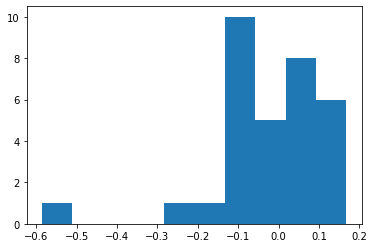

25250 998.2880859375


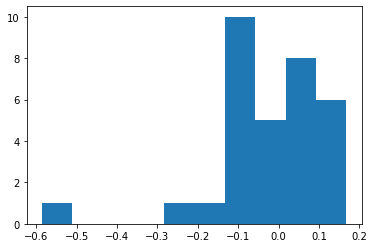

25500 1009.0504150390625


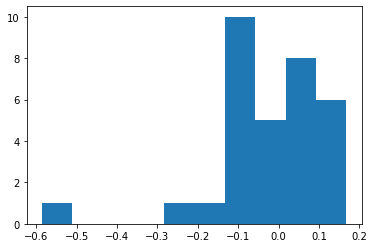

25750 1014.0889282226562


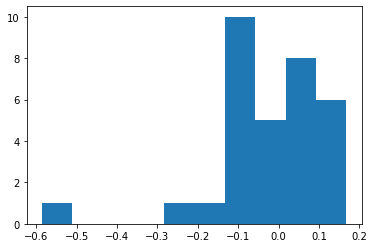

26000 997.892578125


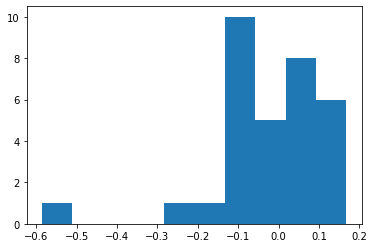

26250 998.6246948242188


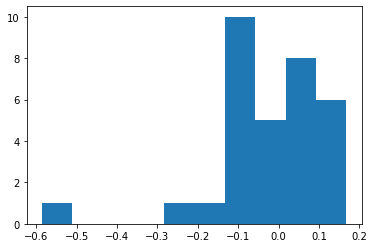

26500 1030.9620361328125


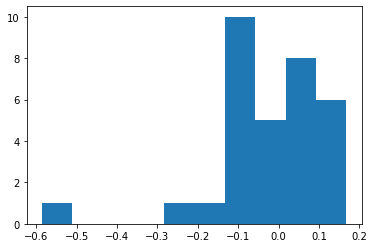

26750 973.458740234375


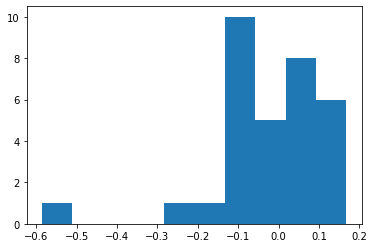

27000 1013.95654296875


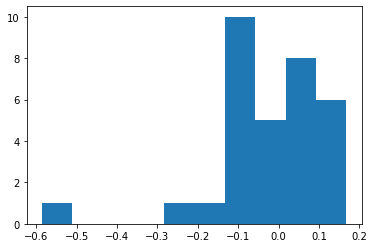

27250 996.6015014648438


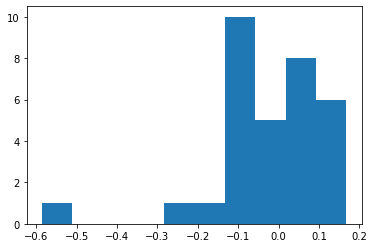

27500 997.7470703125


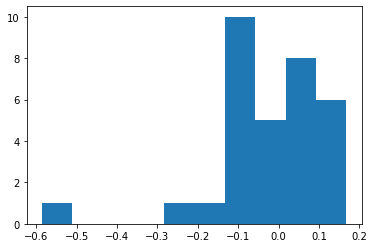

27750 1013.8827514648438


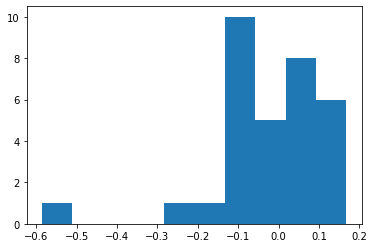

28000 1008.7137451171875


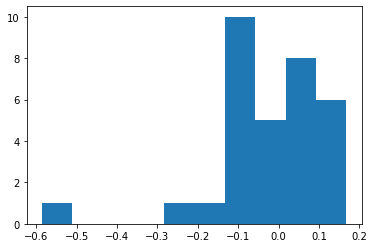

28250 983.747802734375


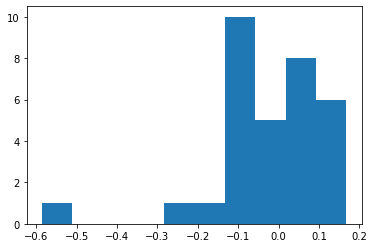

28500 1001.9706420898438


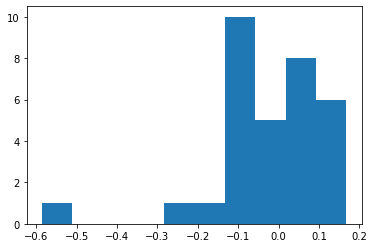

28750 999.3726806640625


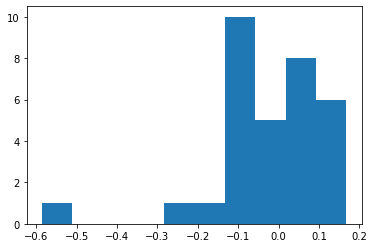

29000 1003.4697265625


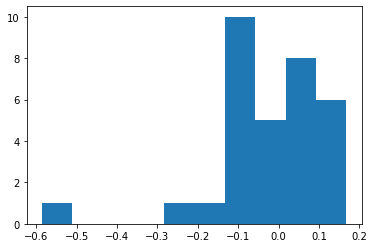

29250 996.2966918945312


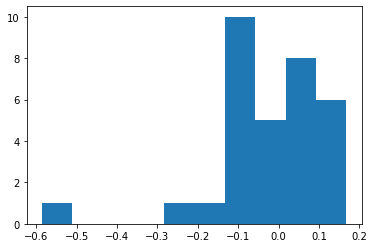

29500 987.8465576171875


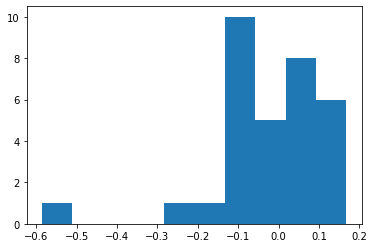

29750 983.2752685546875


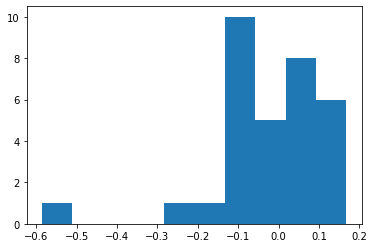

30000 995.1316528320312


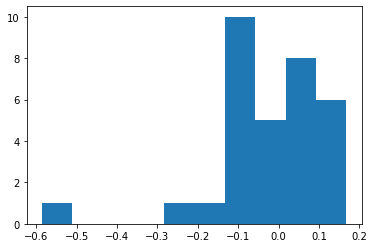

30250 1018.8983154296875


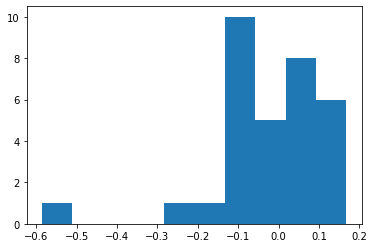

30500 979.871826171875


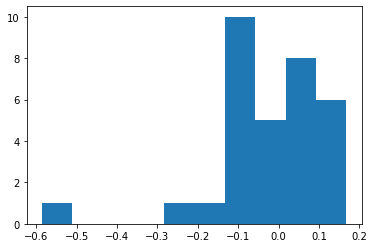

30750 992.9677124023438


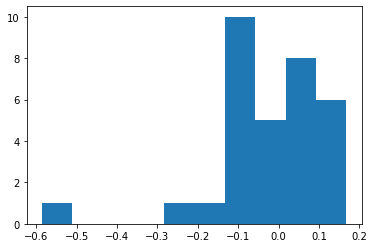

31000 1000.2191162109375


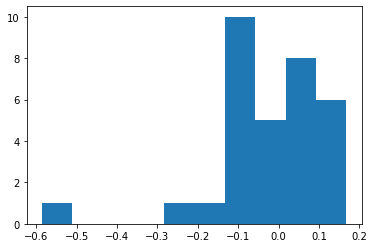

31250 990.0593872070312


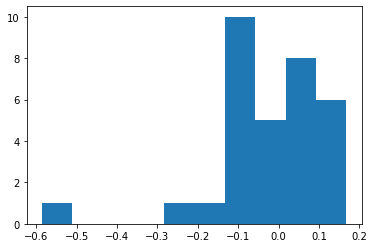

31500 1010.9098510742188


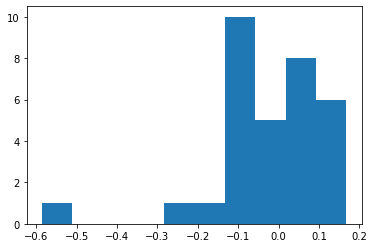

31750 993.1560668945312


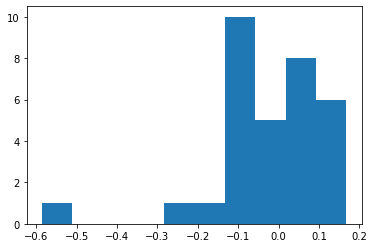

32000 971.9244995117188


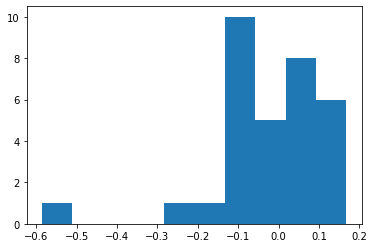

32250 983.2303466796875


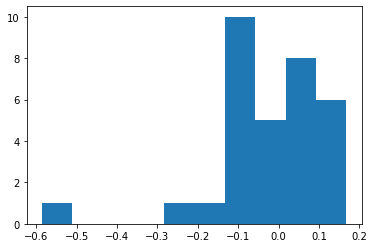

32500 1012.4122314453125


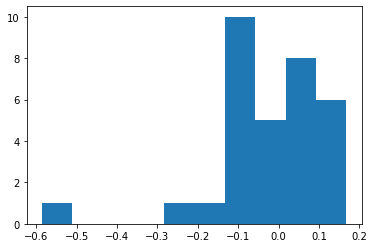

32750 994.1878051757812


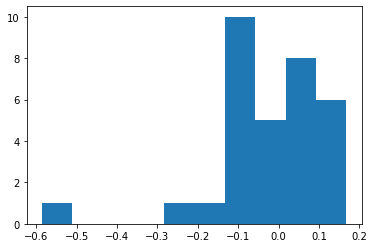

33000 984.7378540039062


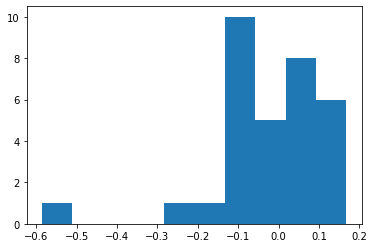

33250 978.7730712890625


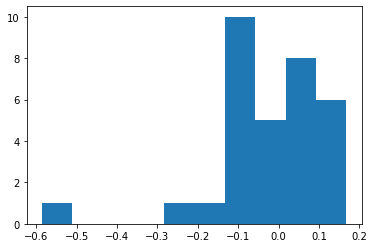

33500 1006.6424560546875


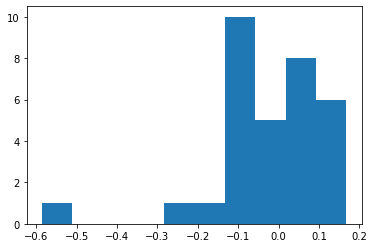

33750 996.8606567382812


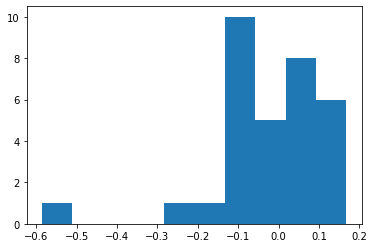

34000 993.6033935546875


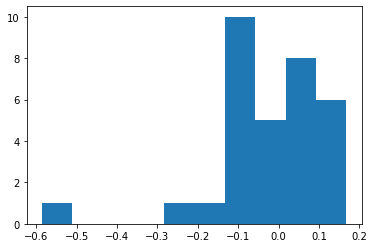

34250 994.005126953125


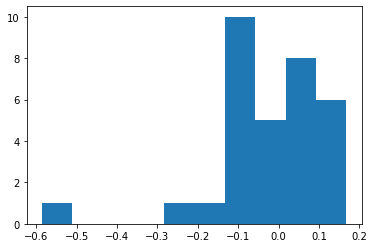

34500 1023.005126953125


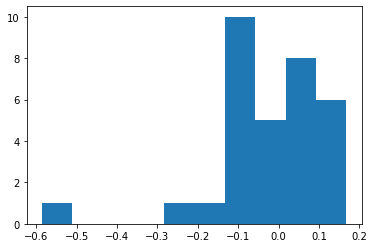

34750 993.3006591796875


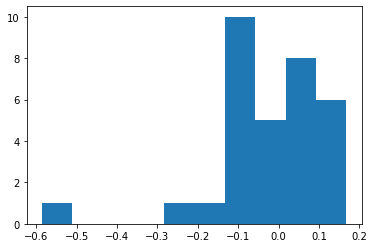

35000 1000.1551513671875


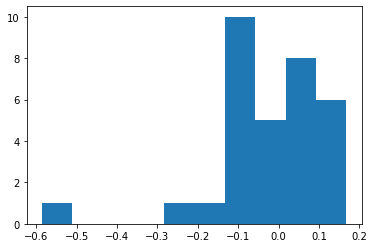

35250 996.5503540039062


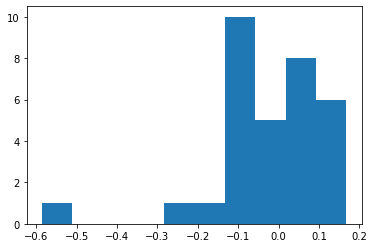

35500 977.030517578125


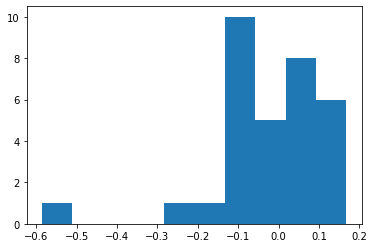

35750 986.3477172851562


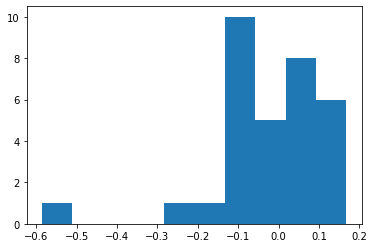

36000 961.7822265625


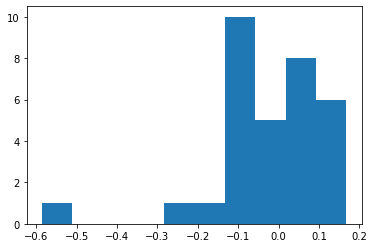

36250 976.0419311523438


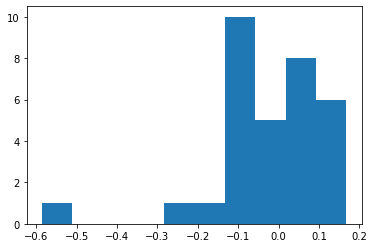

36500 988.0339965820312


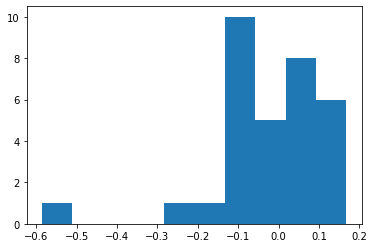

36750 1000.7093505859375


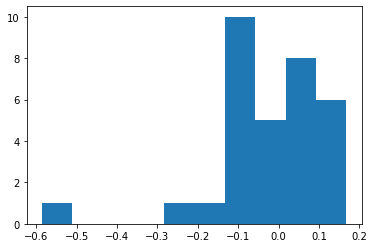

37000 997.379638671875


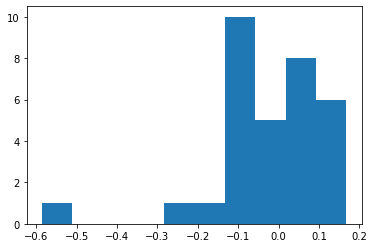

37250 1004.4035034179688


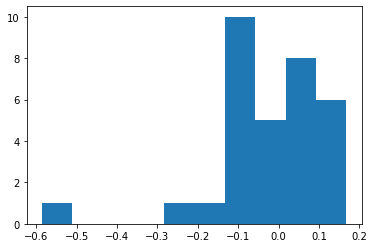

37500 987.2824096679688


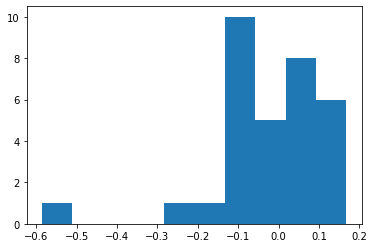

37750 1001.7908935546875


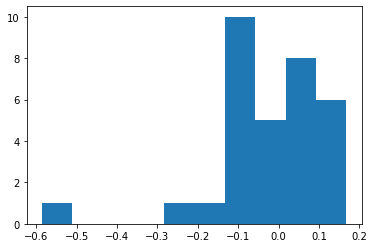

38000 974.4214477539062


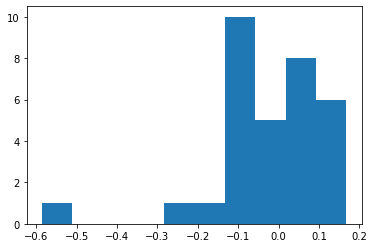

38250 992.9380493164062


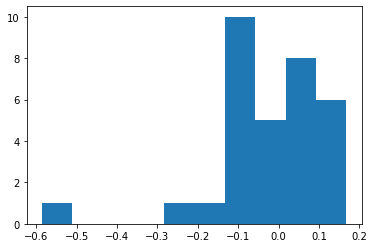

38500 995.801025390625


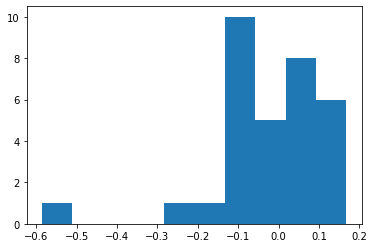

38750 975.5234985351562


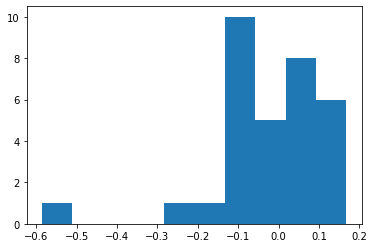

39000 996.6461791992188


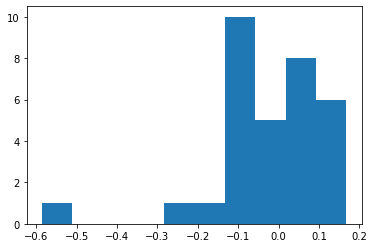

39250 1002.503662109375


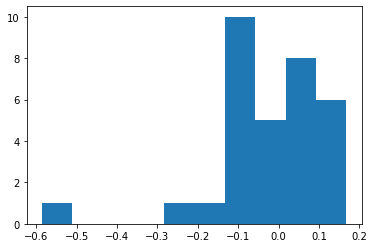

39500 1007.4324951171875


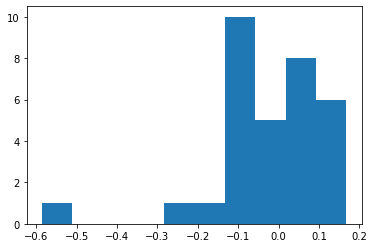

39750 994.6603393554688


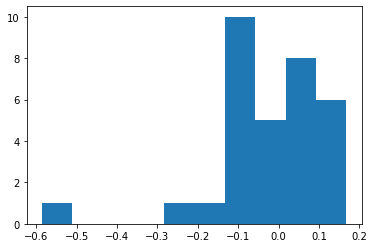

40000 990.7979736328125


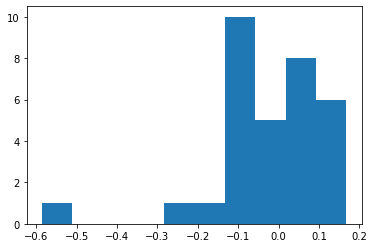

40250 1002.6763916015625


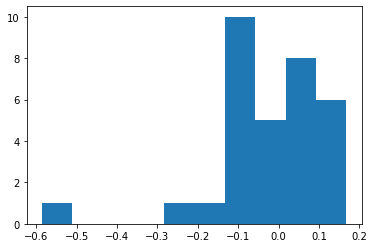

40500 999.6704711914062


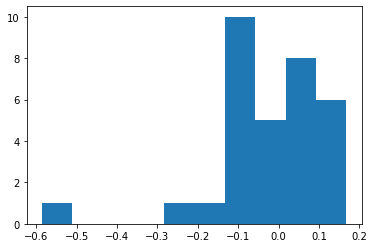

40750 995.2333374023438


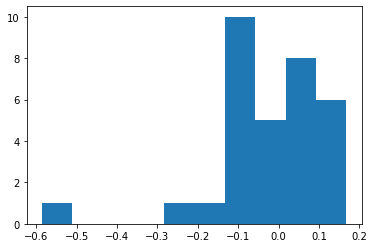

41000 963.6150512695312


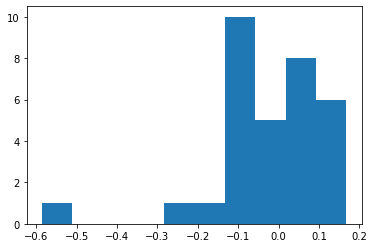

41250 973.7080688476562


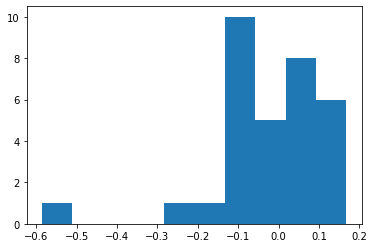

41500 1017.1467895507812


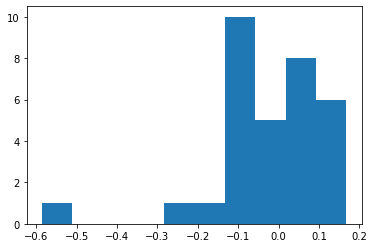

41750 986.299560546875


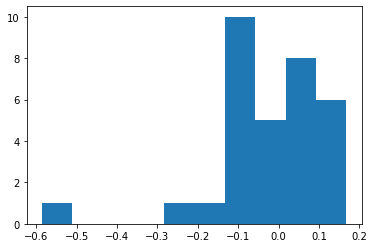

42000 997.01171875


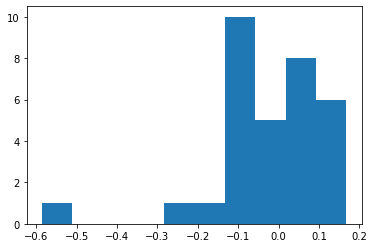

42250 991.782958984375


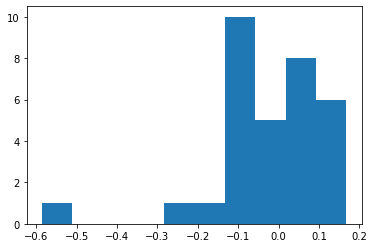

42500 989.0792846679688


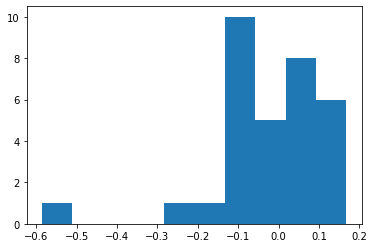

42750 994.4164428710938


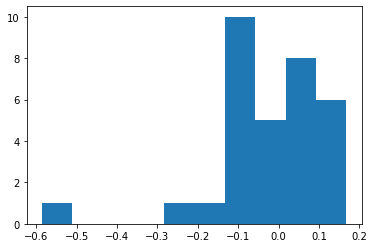

43000 998.0724487304688


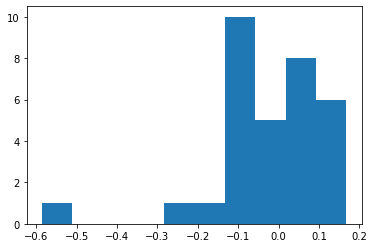

43250 973.8856201171875


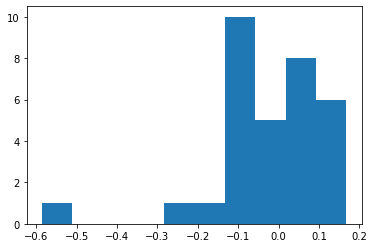

43500 1001.1217651367188


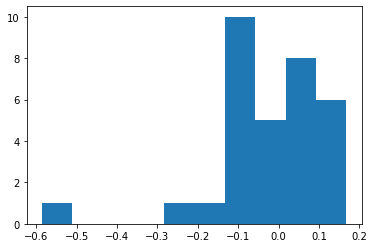

43750 1019.2346801757812


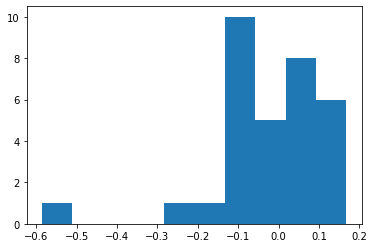

44000 1014.2590942382812


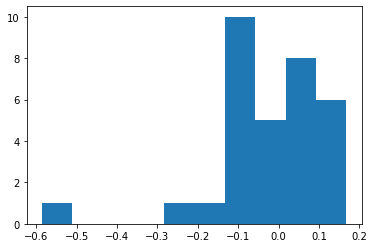

44250 1019.201171875


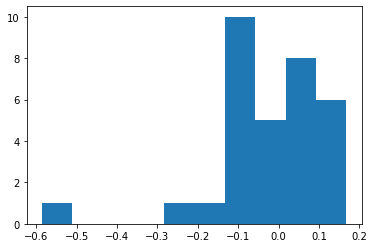

44500 993.7152099609375


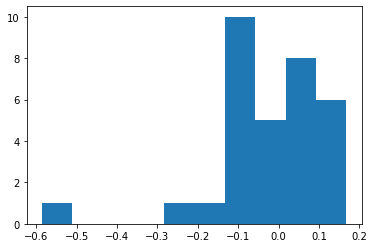

44750 1003.921142578125


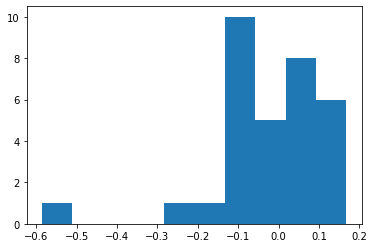

45000 985.7959594726562


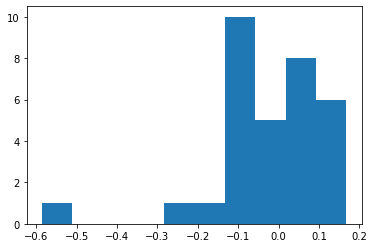

45250 1012.47900390625


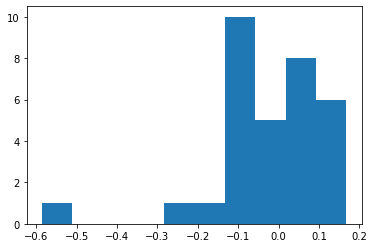

45500 1003.849853515625


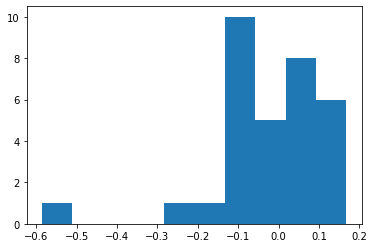

45750 1028.252197265625


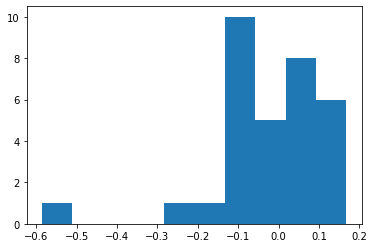

46000 989.446533203125


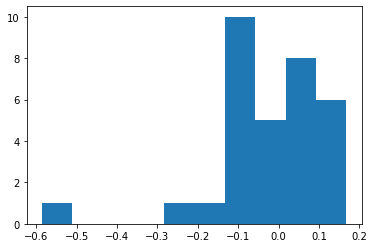

46250 981.4437866210938


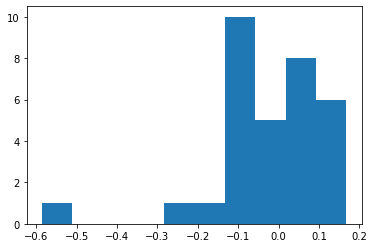

46500 1000.2252807617188


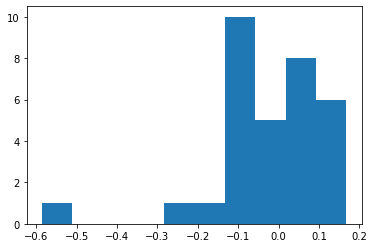

46750 992.921630859375


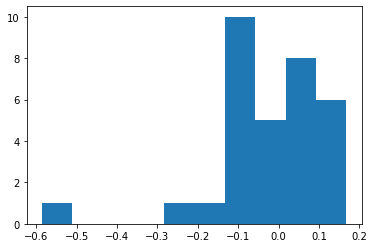

47000 1000.1011962890625


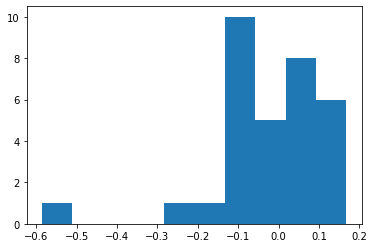

47250 1000.6401977539062


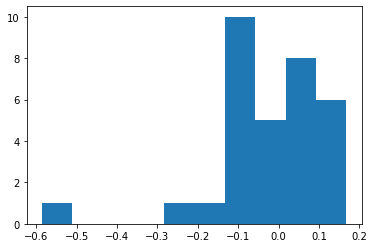

47500 1001.4287109375


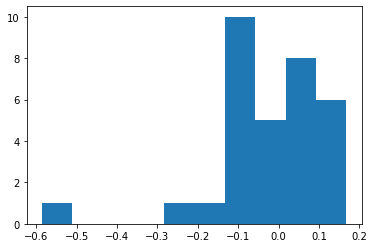

47750 1013.0284423828125


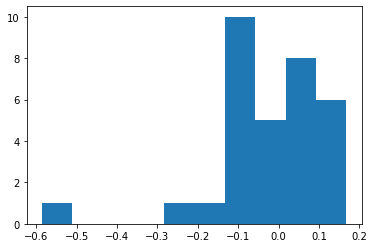

48000 1016.8272094726562


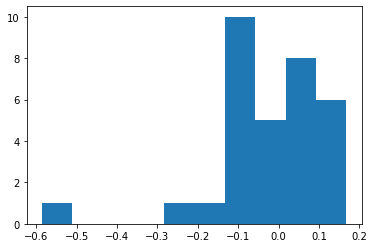

48250 993.6058349609375


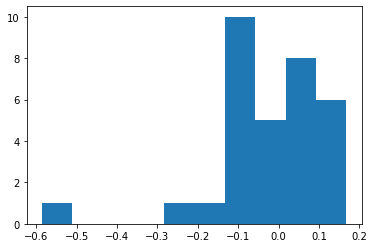

48500 1007.5198974609375


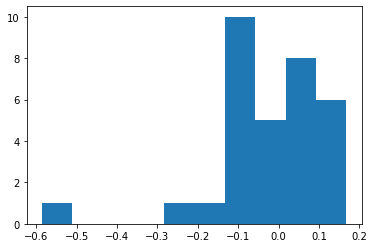

48750 1026.7713623046875


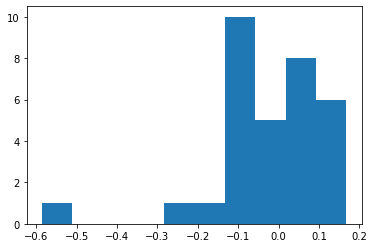

49000 1008.7723388671875


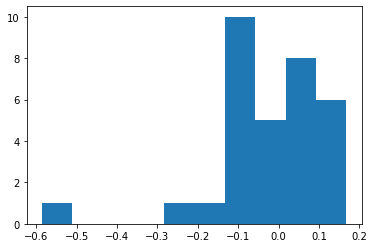

49250 983.7614135742188


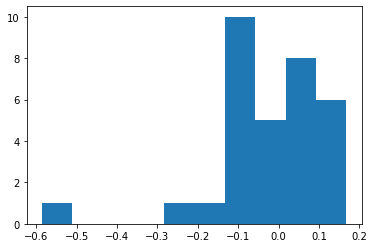

49500 995.0617065429688


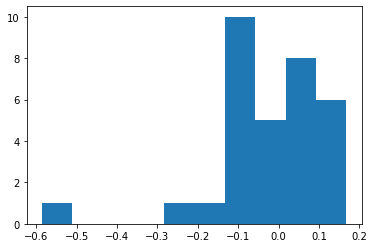

49750 981.3184204101562


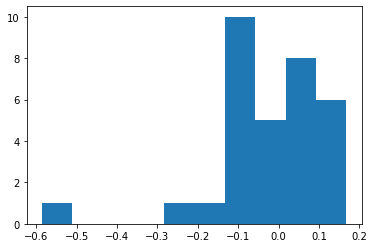

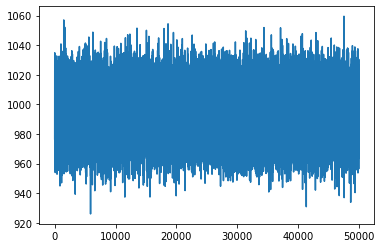

In [260]:
epochs = 50000
learning_rate =0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
weights = []
#x = torch.Tensor(data[:batch_size,:])
base_log_probs = torch.log(base.probs)
model.train()
for e in range(epochs): 
    
    #x = d.sample(batch_size)
    #x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
    x = int_moons_sample(batch_size).float()
    
    optimizer.zero_grad()
    zs = model.reverse(x)
    #zs = model.reverse( x ) # there is no log det jacobian here. 
    #print(zs)
    # get the back output after every transformation currently!
    #print(back_probs)
    logprob = zs*base_log_probs
    #logprob = base.log_prob(zs)
    #print(logprob)
    loss = -torch.sum(logprob)
    #print(loss)
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%250==0:
        print(e, loss.item())
        
        
        #plotting the weights of a single layer: 
        
        flow_num = 0
        sub_part = 6
        w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'].detach().numpy() 
        #print(w.shape)
        weights.append(w)
        plt.hist(w[0,:])
        plt.show()
    
plt.plot(losses)
    

In [261]:
ma_loss = [losses[0]]
ind = 1
for l in losses[1:]:
    ma_loss.append( ma_loss[ind-1] +0.01*(l-ma_loss[ind-1]) )
    ind+=1

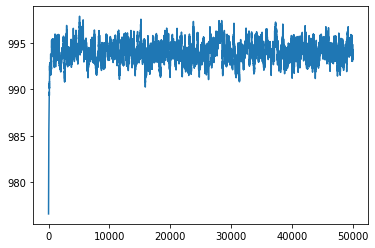

In [262]:
plt.plot(ma_loss)

(124, 2)


Text(0.5, 1.0, 'z -> x')

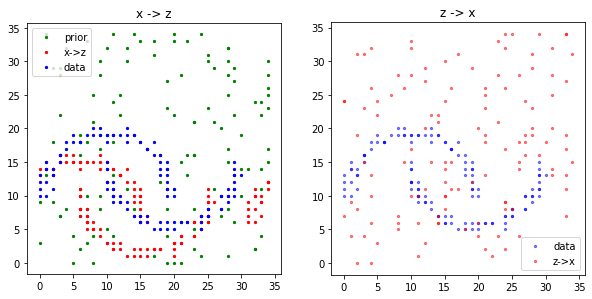

In [263]:
model.eval()

#x = d.sample(128)
x = int_moons_sample(batch_size).float()
zs = model.reverse(x)
z = zs

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample().argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

zs = model.forward(base.sample())
z = zs
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

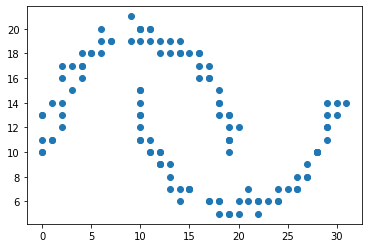

In [141]:
x = int_moons_sample(batch_size)
plot2D(x.argmax(-1))

In [ ]:
a = model.forward(base.sample()).argmax(-1)
plot2D(a)

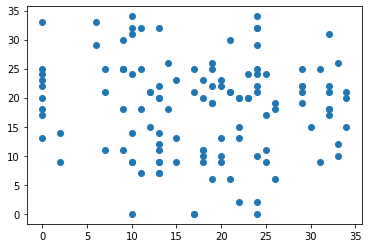

In [142]:
a = model.forward(base.sample()).argmax(-1)
plot2D(a)

# Scraps in making a one hot adder


In [364]:
inputs = torch.tensor(oh[:64,:,:]).float()
loc = layer(inputs)
loc = disc_utils.one_hot_argmax(loc, 0.1).type(inputs.dtype)
print(loc.shape)
disc_utils.one_hot_add(loc, inputs).shape

torch.Size([64, 2, 150])


torch.Size([64, 2, 151])

In [70]:
t_res_sub = disc_utils.one_hot_minus( inputs, loc )

In [34]:
torch.rfft(loc,3).shape

torch.Size([64, 2, 76, 2])

In [35]:
torch.rfft(inputs,3).shape

torch.Size([64, 2, 76, 2])

In [36]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3)

tensor([[[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        ...,

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]],

        [[0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818],
         [0.8212, 0.8514, 0.7500,  ..., 1.6410, 1.3845, 0.9818]]],
       grad_fn=<SqueezeBackward1>)

In [37]:
torch.irfft(torch.rfft(loc,3) * torch.rfft(inputs,3),3).shape

torch.Size([64, 2, 151])

In [247]:
inp = torch.tensor([1,2,3,4,5]).float()-1
inp_oh = torch.zeros((5,5))
inp_oh = inp_oh.scatter_(1, inp.unsqueeze(1).long(), 1)

In [248]:
inp_oh.shape

torch.Size([5, 5])

In [298]:
shifter = disc_utils.one_hot_argmax(torch.rand((5,1,5)), 0.1)
#torch.softmax(torch.rand((5)), -1)
shifter

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 1., 0., 0., 0.]],

        [[0., 0., 0., 1., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]]])

In [299]:
torch.sum(torch.arange(5)*shifter)

tensor(8.)

In [300]:
shifter.shape

torch.Size([5, 1, 5])

In [348]:
shifter[0,0,:]

tensor([0., 0., 1., 0., 0.])

In [349]:
inp_oh[1,:] #0-3=-3%5 = 2
# 1-3=-2%5=3
# 1+3 = 4 % 5 = 1


# 1 - 2 = -1 %5  = 4
# 1+2 = 3%5 = 3

tensor([0., 1., 0., 0., 0.])

In [350]:
torch.einsum('...v,...uv->...u', inp_oh[1,:].float(), shift_mat[0,0,:,:].float())

tensor([0., 0., 0., 0., 1.])

In [351]:
shift_mat = torch.stack( 
    [torch.roll(shifter, i, dims=-1) for i in (range(5))],
    dim=-2).float()
shift_mat.shape


torch.Size([5, 1, 5, 5])

In [352]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [342]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [343]:
inp_oh.shape

torch.Size([5, 5])

In [344]:
shift_mat.shape

torch.Size([5, 1, 5, 5])

In [354]:
shifter[:,0,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.]])

In [353]:
inp_oh

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [362]:
shift_mat[0,0,:,:]

tensor([[0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [359]:
shift_mat[0,0,:,:].T

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [360]:
shift_mat_T = torch.transpose(shift_mat,-1,-2)

In [361]:
torch.einsum('...v,...uv->...u', inp_oh.unsqueeze(1).float(), shift_mat_T.float())

tensor([[[0., 0., 1., 0., 0.]],

        [[0., 0., 1., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1.]]])

In [86]:
inputs.shape

TensorShape([64, 2, 150])

In [87]:
loc.shape

TensorShape([64, 2, 150])

In [273]:
import tensorflow as tf
import edward2 as ed2
loc = tf.constant(loc.detach().numpy())
inputs = tf.constant(inputs.detach().numpy())

In [371]:
import disc_utils

In [372]:
tor_add = disc_utils.one_hot_add_simple(inputs, loc)

/Users/trentonbricken/protein-gen/notebooks/disc_utils.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = scale.type( inputs.dtype)


In [376]:
tor_add.shape

torch.Size([64, 2, 150])

In [375]:
j=4
print( tor_add[j,0,:].argmax(), loc[j,0,:].argmax(), inputs[j,0,:].argmax())

tensor(101) tensor(20) tensor(81)


In [283]:

res_add = ed2.tensorflow.layers.utils.one_hot_add(loc,inputs)
res_add[0,0,:].numpy().argmax()

91

In [284]:
loc[0,0,:].numpy().argmax()

20

In [285]:
inputs[0,0,:].numpy().argmax()

71

In [79]:
def one_hot_simp_add(inputs, shift):
  """Performs (inputs - shift) % vocab_size in the one-hot space.
  Args:
    inputs: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor.
    shift: Tensor of shape `[..., vocab_size]`. Typically a soft/hard one-hot
      Tensor specifying how much to shift the corresponding one-hot vector in
      inputs. Soft values perform a "weighted shift": for example,
      shift=[0.2, 0.3, 0.5] performs a linear combination of 0.2 * shifting by
      zero; 0.3 * shifting by one; and 0.5 * shifting by two.
  Returns:
    Tensor of same shape and dtype as inputs.
  """
  # TODO(trandustin): Implement with circular conv1d.
  inputs = tf.convert_to_tensor(inputs)
  shift = tf.cast(shift, inputs.dtype)
  vocab_size = inputs.shape[-1]
  
  # Form a [..., vocab_size, vocab_size] matrix. Each batch element of
  # inputs will vector-matrix multiply the vocab_size x vocab_size matrix. This
  # "shifts" the inputs batch element by the corresponding shift batch element.
  shift_matrix = tf.stack([tf.roll(shift, i, axis=-1)
                           for i in range(vocab_size)], axis=-2)
  outputs = tf.einsum('...v,...uv->...u', inputs, shift_matrix)
  return outputs

In [83]:
res_add_simple = one_hot_simp_add(inputs, -loc)


In [175]:
res_add

<tf.Tensor: id=966, shape=(64, 2, 150), dtype=float32, numpy=
array([[[-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, ...,
          2.07518425e-09,  1.41010847e-08,  2.90336484e-08],
        [-4.53988704e-08, -1.05245928e-08, -3.14599333e-08, ...,
          2.92471771e-08, -4.65775791e-08,  8.32149425e-08]],

       [[-3.41733291e-08, -4.92956538e-08,  9.18260312e-08, ...,
         -6.81949146e-08,  3.31483285e-08, -1.94591241e-08],
        [ 3.76701365e-07,  2.26353151e-07,  1.23996514e-07, ...,
         -5.16586134e-08,  9.79530590e-09, -7.09407971e-07]],

       [[-1.29540766e-07,  3.38414630e-08, -3.11788995e-08, ...,
         -4.34769838e-08, -6.02295458e-09, -4.69469548e-08],
        [ 1.04904174e-07,  2.37671586e-07, -9.71124194e-08, ...,
         -5.45487637e-08, -5.72065382e-08,  1.21280365e-07]],

       ...,

       [[ 5.99026677e-08, -6.21348306e-08, -2.20887088e-07, ...,
          7.00678342e-08,  2.92297159e-07, -6.02593445e-07],
        [-1.31527585e-07,  2.42835814

In [84]:
res_add_simple[0,0,:5]

<tf.Tensor: id=2362, shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>

In [85]:
res_add == res_add_simple

<tf.Tensor: id=2363, shape=(64, 2, 150), dtype=bool, numpy=
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       ...,

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])>

In [64]:
res_sub = ed2.tensorflow.layers.utils.one_hot_minus(inputs, loc )

In [65]:
res_add[0,0,:5]

<tf.Tensor: id=1428, shape=(5,), dtype=float32, numpy=
array([-1.39077505e-08,  6.16050926e-08,  8.06805431e-08, -8.64888676e-08,
        1.04205597e-07], dtype=float32)>

In [73]:
res_sub.numpy() == t_res_sub.detach().numpy()

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])